Metabolic EP
=====

Load julia module
-----

In [3]:
# eventually, install repository with import Pkg; Pkg.clone("https://github.com/anna-pa-m/Metabolic-EP/","MetabolicEP.jl")
#import Pkg; Pkg.clone("https://github.com/anna-pa-m/Metabolic-EP/","MetabolicEP.jl")
#using MetabolicEP
include("../src/MetabolicEP.jl")

Main.MetabolicEP

Load test metabolic model
------

In [6]:
#met=MetabolicEP.ReadMatrix(Pkg.Dir.path() * "/MetabolicEP/test/ecoli_core_model.mat");
met=MetabolicEP.ReadMatrix("../data/rbc.mat");
S,b,lb,ub,rxns = MetabolicEP.preprocess(met.S,met.b,met.lb,met.ub,met.rxns);

0 blocked fluxes


Run EP
-----

In [7]:
# Finite β
r = MetabolicEP.metabolicEP(S,b,lb,ub,beta=1e9);

Analyzing a 34 × 46 stoichiometric matrix.
Converging with β=1.0e9 maxth=1.0e-6 maxiter=2000:
it = 190 ɛav = 9.97e-07 ɛvar = 1.06e-07 ɛμ = 1.24e-06 ɛs = 1.20e-07                 40e-04                 06 ɛμ = 8.17e-05 ɛs = 5.34e-06                 


In [9]:
# Beta = Inf 
r0 = MetabolicEP.metabolicEP(S,b,lb,ub,beta=Inf);


Analyzing a 34 × 46 stoichiometric matrix.
Converging with β=Inf maxth=1.0e-6 maxiter=2000:
it = 190 ɛav = 9.98e-07 ɛvar = 1.06e-07 ɛμ = 1.24e-06 ɛs = 1.20e-07                                 


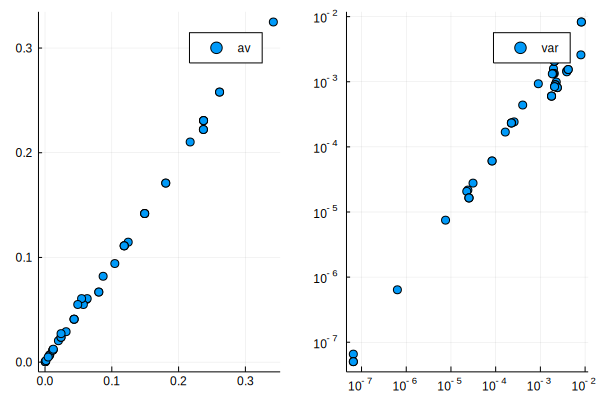

In [22]:
# Compare to naive Hit-and-Run
include("../src/HitAndRun.jl")
nsamples = 1000000
samples = HitAndRun.sample(S,b,lb,ub, nsamples = nsamples);
using Plots, Statistics
sam_mean = mean(samples, dims=1)
sam_var = var(samples, dims=1)
p1 = Plots.scatter(sam_mean', r0.av, label="av")
p2 = Plots.scatter(sam_var', r0.va ,xaxis=:log, yaxis=:log, label="var")
Plots.plot(p1,p2)

Plot marginals
-----
    
Marginals are truncated Normal



$$P(\nu_i)\propto \mathbb{I}[l_i\leq\nu_i\leq u_i]e^{-\frac{(\nu_i-\mu_i)^2}{2s_i}}$$

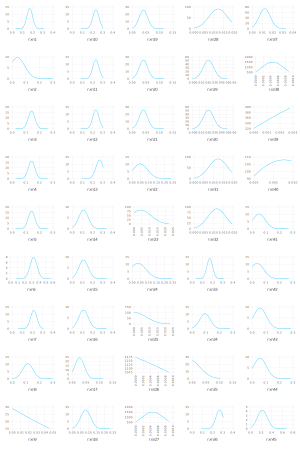

In [17]:
#if you miss these packages, use Pkg.add("Distributions); Pkg.add("Gadfly")
using Distributions, Gadfly

function plotmarg(i)
    μ,s,l,u=r0.μ[i],r0.σ[i],lb[i],ub[i]
    d=Normal(μ,√s);
    D=Truncated(d,l,u);
    #choose bounds to have a sensible plotting range
    m=max(pdf(d,l),pdf(d,u),(l<μ<u) ? 1/sqrt(2pi*s) : 0);
    v=sqrt(-2*s*log(sqrt(2pi*s)*1e-5m));
    l1,l2=max(l,μ-v),min(u,μ+v);
    return Gadfly.plot(x->pdf(D,x),l1,l2,Guide.YLabel(""),Guide.XLabel(met.rxns[i]))
end

#build plot grid with R rows and 5 columns (up to R=19)
R=9
P=[plotmarg(i) for i=1:5R]
Gadfly.set_default_plot_size(30cm,R*5cm)
Gadfly.gridstack(reshape(P,R,5))